Here are balanced classes, so the usual accuracy metric is used:
**Accuracy = True predictions / All predictions**
The baselines are calculated as follows:
1. Sample negative edges. Concatenate node features into edge features. Train Gradient boosting on edges features. Calculate score.
2. Create a graph on existing edges. Train Laplacian Eigenmaps. Sample negative edges. Concatenate node embeddings into edge embeddings. Train Gradient boosting on edge embeddings. Calculate score.
3. Create a graph using existing edges. Sample negative edges. Train a neural network consisting of GCN for node emedding and MLP for link prediction that maps Hadamart product edge embeddings into probability of edge existing. Calculate score.

Baseline for grade 4: beat a minimum score
Baseline for grade 6: beat a mean score

Solution without Graph neural networks

In [1]:
import networkx as nx
import pandas as pd

G = nx.DiGraph()
edges = pd.read_csv('train_edges.txt', header=None, sep=' ')
edges = edges.apply(lambda x: (x[0], x[1]), axis = 1).tolist()
G.add_edges_from(edges)
len(G.nodes())

12588

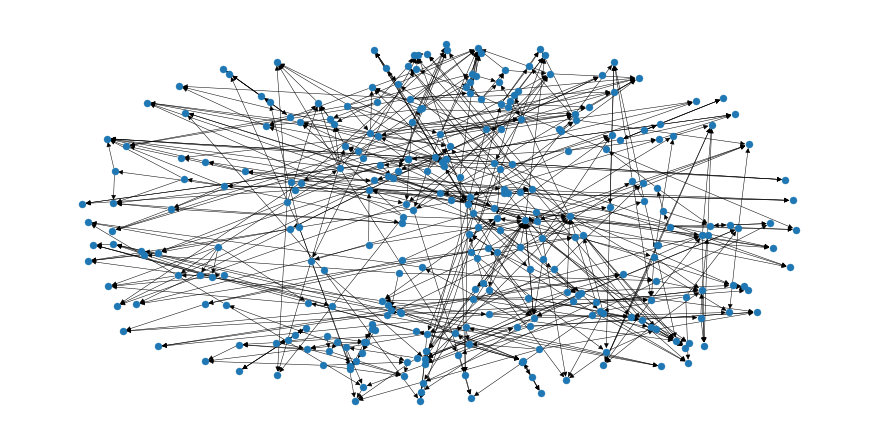

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)


G_core = nx.k_core(G, 3)
nx.draw(G_core, node_size=50, width=0.5, linewidths=0.3, cmap=plt.cm.coolwarm)

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split


def negative_sampling(H):
    negative_edges = set()
    all_edges = list(H.edges)
    nodes = list(H.nodes)
    while len(negative_edges) < len(all_edges):
        u, v = np.random.choice(nodes, size=2)
        if (u != v) and ((u, v) not in all_edges):
            negative_edges.add((u, v))
    return list(negative_edges)

In [4]:
positive_edges = list(G.edges())
positive_label = np.ones(len(positive_edges))
negative_edges = negative_sampling(G)
negative_label = np.zeros(len(negative_edges))
edges = positive_edges + negative_edges
labels = np.hstack((positive_label, negative_label))
train_edges, test_edges, train_labels, test_labels = train_test_split(edges, labels, train_size=0.9, random_state=57, shuffle=True, stratify=labels)

In [5]:
subG = nx.DiGraph()
subG.add_nodes_from(G.nodes)
subG.add_edges_from(train_edges)

In [6]:
from sklearn.decomposition import TruncatedSVD


A = nx.to_numpy_array(subG)
model = TruncatedSVD(n_components=96, n_iter=100, random_state=57)
svd_emb = model.fit_transform(A)

In [7]:
mapping = {val: idx for idx, val in enumerate(subG.nodes)}

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def hadamard_operator(G, embeddings, edges):
    return np.array([embeddings[mapping[u]] * embeddings[mapping[v]] for u, v in edges])

def average_operator(G, embeddings, edges):
    return np.array([embeddings[mapping[u]] / 2 + embeddings[mapping[v]] / 2 for u, v in edges])

def weighted_l1_operator(G, embeddings, edges):
    return np.array([np.abs(embeddings[mapping[u]] - embeddings[mapping[v]]) for u, v in edges])

def weighted_l2_operator(G, embeddings, edges):
    return np.array([np.power(embeddings[mapping[u]] - embeddings[mapping[v]], 2) for u, v in edges])

def neighbor_weighted_l1_operator(H, embeddings, edges):
    res = []
    for u, v in edges:
        u_n = list(map(lambda x: mapping[x], list(G[u]) + [u]))
        v_n = list(map(lambda x: mapping[x], list(G[v]) + [v]))
        u = np.mean(embeddings[u_n], axis=0)
        v = np.mean(embeddings[v_n], axis=0)
        res.append(np.abs(u - v))
    return np.array(res)

def neighbor_weighted_l2_operator(H, embeddings, edges):
    res = []
    for u, v in edges:
        u_n = list(map(lambda x: mapping[x], list(G[u]) + [u]))
        v_n = list(map(lambda x: mapping[x], list(G[v]) + [v]))
        u = np.mean(embeddings[u_n], axis=0)
        v = np.mean(embeddings[v_n], axis=0)
        res.append(np.power(u - v, 2))
    return np.array(res)

operators = {
    "average_operator": average_operator,
    "hadamard_operator": hadamard_operator,
    "weighted_l1_operator": weighted_l1_operator,
    "weighted_l2_operator": weighted_l2_operator,
    "neighbor_weighted_l1_operator": neighbor_weighted_l1_operator,
    "neighbor_weighted_l2_operator": neighbor_weighted_l2_operator
}


for name, operator in operators.items():
    lr = LogisticRegression()
    train_emb = operator(subG, svd_emb, train_edges)
    test_emb = operator(subG, svd_emb, test_edges)
    lr.fit(train_emb, train_labels)
    preds = lr.predict(test_emb)
    print(accuracy_score(test_labels, preds))

0.5364746945898778
0.525305410122164
0.5333333333333333


/home/dmitry/anaconda3/envs/made/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5333333333333333
0.5595113438045375
0.5326352530541012



### Mean Baseline

In [14]:
unG = nx.DiGraph()
un_edges = pd.read_csv('unlabeled_edges.txt', header=None, sep=' ')
un_edges = un_edges.apply(lambda x: (x[0], x[1]), axis = 1).tolist()
unG.add_edges_from(edges)

In [173]:
lr = LogisticRegression()
train_emb = average_operator(subG, emb, train_edges)
un_emb = average_operator(subG, emb, un_edges)
lr.fit(train_emb, train_labels)
preds = lr.predict(un_emb).astype(int)
pd.Series(preds).to_csv('average_prediction.txt', index=False, header=False)

### Node features

In [9]:
node_emb = pd.read_csv('node_feat.txt', index_col=False, header=None, sep=' ')
merged_emb = np.hstack((svd_emb, node_emb))
out_train = np.array([merged_emb[mapping[u]] for u,v in train_edges])
in_train = np.array([merged_emb[mapping[v]] for u,v in train_edges])
out_test = np.array([merged_emb[mapping[u]] for u,v in test_edges])
in_test = np.array([merged_emb[mapping[v]] for u,v in test_edges])
out_un = np.array([merged_emb[mapping[u]] for u,v in un_edges])
in_un = np.array([merged_emb[mapping[v]] for u,v in un_edges])

In [18]:
from torch import nn
import torch
# import torch.nn.functional as F


class NodeNet(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features
    ):
        super().__init__()
        self.out_linear = nn.Linear(in_features, hidden_features)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.in_linear = nn.Linear(in_features, hidden_features)
        self.linear = nn.Linear(hidden_features, 2)

    def forward(self, whole_input):
        out_vec, in_vec = whole_input
        out_vec = self.relu1(self.out_linear(out_vec))
        in_vec = self.relu2(self.out_linear(in_vec))
        vec = out_vec * in_vec
        o = self.linear(vec)
        return o

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
def get_batch(in_feat, out_feat, y, batch_size):
    batch_indices = np.random.randint(0, len(y), size=batch_size)
    y_batch = pd.DataFrame(y[batch_indices], columns=[1])
    y_batch[0] = 1 - y_batch[1]
    return (
               torch.tensor(in_feat[batch_indices], dtype=torch.float, device=device),
               torch.tensor(out_feat[batch_indices], dtype=torch.float, device=device)), \
           torch.tensor(y_batch.values, dtype=torch.float, device=device)

In [21]:
from tqdm.notebook import tqdm


epochs = 300
model = NodeNet(128, 64).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
batch_size=64

for epoch in tqdm(range(epochs)):
    history, test_history = [], []
    for iteration in range(2 * len(train_labels) // batch_size):
        # Preprocessing the batch data and target
        X_batch, y_batch = get_batch(out_train, in_train, train_labels, 2)
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        history.append(loss.to('cpu').detach().numpy())

    with torch.no_grad():
        loss = []
        for iteration in range(2 * len(test_labels) // batch_size):
            X_batch, y_batch = get_batch(out_test, in_test, test_labels, 2)
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            test_history.append(loss.to('cpu').detach().numpy())
    if epoch % 25 == 24:
        print(np.mean(history), np.mean(test_history))

  0%|          | 0/300 [00:00<?, ?it/s]

0.65945745 0.75646913
0.67616355 0.70412916
0.6604038 0.6964877
0.664545 0.6699459
0.64804614 0.67036647
0.640492 0.70997864
0.6303252 0.7008415
0.6466068 0.66219157
0.6685863 0.6948802
0.63834244 0.7371204
0.6469443 0.8150831
0.64711636 0.66691333


In [22]:
m = torch.nn.Sequential(torch.nn.Softmax())
preds = np.round(m(model.to('cpu')((torch.tensor(out_test, dtype=torch.float), torch.tensor(in_test, dtype=torch.float))))[:, 0].detach().numpy())
print(accuracy_score(test_labels, preds))

0.5741710296684118


/home/dmitry/anaconda3/envs/made/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [23]:
out_un = np.array([merged_emb[mapping[u]] for u,v in un_edges])
in_un = np.array([merged_emb[mapping[v]] for u,v in un_edges])
preds = np.round(m(model.to('cpu')((torch.tensor(out_un, dtype=torch.float), torch.tensor(in_un, dtype=torch.float))))[:, 0].detach().numpy())
pd.Series(preds).astype(int).to_csv('nodenet_prediction.txt', index=False, header=False)

/home/dmitry/anaconda3/envs/made/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Test LR

In [24]:
lr = LogisticRegression(max_iter=1000, tol=1e-5)
train_emb = np.hstack([out_train, in_train])
test_emb = np.hstack([out_test, in_test])
lr.fit(train_emb, train_labels)
preds = lr.predict(test_emb).astype(int)
print(accuracy_score(test_labels, preds))
un_emb = np.hstack([out_un, in_un])
preds = lr.predict(un_emb).astype(int)
pd.Series(preds).to_csv('lr_concat.txt', index=False, header=False)

0.543804537521815


### Test LGB

In [37]:
import lightgbm as lgb
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        # 'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        # 'subsample_freq': trial.suggest_int('subsample_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, log=True)
    }
    lgb_model = lgb.LGBMClassifier(**params)
    lgb_model.fit(train_emb, train_labels)
    preds = lgb_model.predict(test_emb).astype(int)
    accuracy = accuracy_score(test_labels, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# lgb_model = lgb.LGBMClassifier()
# lgb_model.fit(train_emb, train_labels)
# preds = lgb_model.predict(test_emb).astype(int)
# accuracy_score(test_labels, preds)
# preds = lr.predict(un_emb).astype(int)
# pd.Series(preds).to_csv('lr_concat.txt', index=False, header=False)

[I 2022-03-27 11:41:50,342] A new study created in memory with name: no-name-ba62702d-496b-4eec-a02a-a14300df2fba
[I 2022-03-27 11:41:53,433] Trial 0 finished with value: 0.5762652705061082 and parameters: {'boosting_type': 'goss', 'reg_alpha': 0.01475111558226327, 'reg_lambda': 0.0024313707246367694, 'num_leaves': 70, 'colsample_bytree': 0.7191503926197116, 'min_child_samples': 45, 'learning_rate': 0.02754465301125529, 'n_estimators': 275}. Best is trial 0 with value: 0.5762652705061082.
[I 2022-03-27 11:41:54,659] Trial 1 finished with value: 0.5595113438045375 and parameters: {'boosting_type': 'dart', 'reg_alpha': 4.498596720655892e-05, 'reg_lambda': 3.4933440600446835, 'num_leaves': 43, 'colsample_bytree': 0.5227945157715993, 'min_child_samples': 20, 'learning_rate': 0.0452164200098471, 'n_estimators': 126}. Best is trial 0 with value: 0.5762652705061082.
[I 2022-03-27 11:41:56,746] Trial 2 finished with value: 0.5699825479930192 and parameters: {'boosting_type': 'gbdt', 'reg_alpha

In [39]:
trial = study.best_trial
lgb_model = lgb.LGBMClassifier(**trial.params)
lgb_model.fit(train_emb, train_labels)
preds = lgb_model.predict(test_emb).astype(int)
print(accuracy_score(test_labels, preds))
preds = lgb_model.predict(un_emb).astype(int)
pd.Series(preds).to_csv('lgb_pred.txt', index=False, header=False)

0.6139616055846422


In [41]:
from sklearn.preprocessing import StandardScaler


# scaled_train = scaler.fit_transform()
# scaled_test = scaler.transform()
for name, operator in operators.items():
    lr = LogisticRegression()
    scaler = StandardScaler()
    train_edge_emb = scaler.fit_transform(operator(subG, merged_emb, train_edges))
    test_edge_emb = scaler.transform(operator(subG, merged_emb, test_edges))
    lr.fit(train_edge_emb, train_labels)
    preds = lr.predict(test_edge_emb)
    print(accuracy_score(test_labels, preds))

0.5452006980802793


/home/dmitry/anaconda3/envs/made/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.562303664921466
0.5553228621291448


/home/dmitry/anaconda3/envs/made/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5476439790575917
0.7699825479930192
0.7616055846422338


In [48]:
lr = LogisticRegression()
scaler = StandardScaler()
train_edge_emb = scaler.fit_transform(neighbor_weighted_l1_operator(subG, merged_emb, train_edges))
test_edge_emb = scaler.transform(neighbor_weighted_l1_operator(subG, merged_emb, test_edges))
lr.fit(train_edge_emb, train_labels)
preds = lr.predict(test_edge_emb)
print(accuracy_score(test_labels, preds))
un_edge_emb = scaler.transform(neighbor_weighted_l1_operator(subG, merged_emb, un_edges))
preds = lr.predict(un_edge_emb).astype(int)
pd.Series(preds).to_csv('lr_pred.txt', index=False, header=False)

0.7699825479930192


In [49]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'goss', 'dart']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, log=True)
    }
    lgb_model = lgb.LGBMClassifier(**params)
    lgb_model.fit(train_edge_emb, train_labels)
    preds = lgb_model.predict(test_edge_emb).astype(int)
    accuracy = accuracy_score(test_labels, preds)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-03-27 12:16:30,899] A new study created in memory with name: no-name-af954270-595d-4160-b9fe-6b56555ec3cd
[I 2022-03-27 12:16:36,986] Trial 0 finished with value: 0.8010471204188482 and parameters: {'boosting_type': 'dart', 'reg_alpha': 2.845017090151506e-06, 'reg_lambda': 0.00036635252148962803, 'num_leaves': 14, 'colsample_bytree': 0.8234014903807743, 'min_child_samples': 92, 'learning_rate': 0.1521761553067744, 'n_estimators': 1087}. Best is trial 0 with value: 0.8010471204188482.
[I 2022-03-27 12:16:39,333] Trial 1 finished with value: 0.7975567190226877 and parameters: {'boosting_type': 'dart', 'reg_alpha': 0.0027007497034097585, 'reg_lambda': 0.13552089222737657, 'num_leaves': 77, 'colsample_bytree': 0.7400269246886191, 'min_child_samples': 89, 'learning_rate': 0.33868722155534037, 'n_estimators': 252}. Best is trial 0 with value: 0.8010471204188482.
[I 2022-03-27 12:16:39,971] Trial 2 finished with value: 0.7808027923211169 and parameters: {'boosting_type': 'gbdt', 'reg_

In [50]:
trial = study.best_trial
lgb_model = lgb.LGBMClassifier(**trial.params)
lgb_model.fit(train_edge_emb, train_labels)
preds = lgb_model.predict(test_edge_emb).astype(int)
print(accuracy_score(test_labels, preds))
preds = lgb_model.predict(un_edge_emb).astype(int)
pd.Series(preds).to_csv('lgb_pred.txt', index=False, header=False)

0.8129144851657941


In [57]:
def neighbor_weighted_l1_operator(H, embeddings, edges):
    res = []
    for u, v in edges:
        u_n = list(map(lambda x: mapping[x], list(G[u]) + [u]))
        v_n = list(map(lambda x: mapping[x], list(G[v]) + [v]))
        u = np.mean(embeddings[u_n], axis=0)
        v = np.mean(embeddings[v_n], axis=0)
        res.append(np.abs(u - v))
    return np.array(res)


lr = LogisticRegression()
scaler = StandardScaler()
train_edge_emb_ = scaler.fit_transform(neighbor_weighted_l1_operator(subG, node_emb.values, train_edges))
test_edge_emb_ = scaler.transform(neighbor_weighted_l1_operator(subG, node_emb.values, test_edges))
lr.fit(train_edge_emb_, train_labels)
preds = lr.predict(test_edge_emb_)
print(accuracy_score(test_labels, preds))
# un_edge_emb_ = scaler.transform(neighbor_weighted_l1_operator(subG, node_emb, un_edges))
# preds = lr.predict(un_edge_emb_).astype(int)
# pd.Series(preds).to_csv('lr_pred.txt', index=False, header=False)

0.7619546247818499


In [59]:
trial = study.best_trial
lgb_model = lgb.LGBMClassifier(**trial.params)
lgb_model.fit(train_edge_emb_, train_labels)
preds = lgb_model.predict(test_edge_emb_).astype(int)
print(accuracy_score(test_labels, preds))

0.7909249563699825


#### Вывод: SVD эмбединги не работают

### Попробовать Node2Vec через случайные блуждания